## LSTM Language Model for Penn Tree Bank data


In [0]:
from __future__ import print_function
import os
import matplotlib.pyplot as plt
import numpy as np
import chainer
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import os
from argparse import Namespace
import re
import torch.optim as optim
import math
import time
import torch.optim as optim


# Hyperparameters
seq_size = 35
batch_size = 20
embedding_size = 650
lstm_size = 650
num_layers = 2
gradients_norm = 5
epochs = 75

# For optimizer
lr = 0.001
weight_decay = 2e-5 # L2 regularization


#Dropout
dropout=0.5 #locked
dropouti=0.5 #locked
dropoute=0.1 #emb dropout



In [2]:
# Penn Treebank Data

train, val, test = chainer.datasets.get_ptb_words()

vocab_to_int = chainer.datasets.get_ptb_words_vocabulary()
int_to_vocab = dict((v,k) for k,v in vocab_to_int.items())
n_vocab = len(vocab_to_int)
print('Vocabulary size', n_vocab)

#TRAINING SET

int_text = train
num_batches = int(len(int_text) / (seq_size * batch_size))
in_text = int_text[:num_batches * batch_size * seq_size]
out_text = np.zeros_like(in_text)
out_text[:-1] = in_text[1:]
out_text[-1] = in_text[0]
in_text = np.reshape(in_text, (batch_size, -1))
out_text = np.reshape(out_text, (batch_size, -1))
print('Training size', len(int_text))

#VALIDATION SET

int_text1 = val
num_batches = int(len(int_text1) / (seq_size * batch_size))
in_text1 = int_text1[:num_batches * batch_size * seq_size]
out_text1 = np.zeros_like(in_text1)
out_text1[:-1] = in_text1[1:]
out_text1[-1] = in_text1[0]
in_text_val = np.reshape(in_text1, (batch_size, -1))
out_text_val = np.reshape(out_text1, (batch_size, -1))
print('Validation size', len(int_text1))


#TEST SET 

int_text2 = test
num_batches = int(len(int_text2) / (seq_size * batch_size))
in_text2 = int_text2[:num_batches * batch_size * seq_size]
out_text2 = np.zeros_like(in_text2)
out_text2[:-1] = in_text2[1:]
out_text2[-1] = in_text2[0]
in_text_test = np.reshape(in_text2, (batch_size, -1))
out_text_test = np.reshape(out_text2, (batch_size, -1))
print('Test size', len(int_text2))



Vocabulary size 10000
Training size 929589
Validation size 73760
Test size 82430


## Define regularization functions and classes



In [0]:
class LockedDropout(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, dropout=0.5):
        if not self.training or not dropout:
            return x
        m = x.data.new(1, x.size(1), x.size(2)).bernoulli_(1 - dropout)
        mask = Variable(m, requires_grad=False) / (1 - dropout)
        mask = mask.expand_as(x)
        return mask * x

In [0]:

def embedded_dropout(embed, words, dropout=0.1, scale=None):
  if dropout:
    mask = embed.weight.data.new().resize_((embed.weight.size(0), 1)).bernoulli_(1 - dropout).expand_as(embed.weight) / (1 - dropout)
    masked_embed_weight = mask * embed.weight
  else:
    masked_embed_weight = embed.weight
  if scale:
    masked_embed_weight = scale.expand_as(masked_embed_weight) * masked_embed_weight

  padding_idx = embed.padding_idx
  if padding_idx is None:
      padding_idx = -1

  X = torch.nn.functional.embedding(words, masked_embed_weight,
    padding_idx, embed.max_norm, embed.norm_type,
    embed.scale_grad_by_freq, embed.sparse
  )
  return X

In [0]:
class RNNModule(nn.Module):
    
    def __init__(self, n_vocab, seq_size, 
                 embedding_size, lstm_size, num_layers, dropout=0.5, dropouti=0.5, dropoute=0.1):
        super(RNNModule, self).__init__()
       
        self.seq_size = seq_size
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.embedding_size = embedding_size
        self.lockdrop = LockedDropout()
        self.idrop = nn.Dropout(dropouti)
        self.drop = nn.Dropout(dropout)
        
        
        self.embedding = nn.Embedding(n_vocab, embedding_size)

        self.lstm = nn.LSTM(embedding_size, lstm_size, 
                            num_layers, batch_first=True)
      
        self.dense = nn.Linear(lstm_size, n_vocab)
        
      
        
        self.dropout = dropout
        self.dropouti = dropouti
        self.dropoute = dropoute

      

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.dense.bias.data.fill_(0)
        self.dense.weight.data.uniform_(-initrange, initrange)
        
    def forward(self, x, prev_state):
        embed = embedded_dropout(self.embedding, x, dropout=self.dropoute if self.training else 0)
        embed = self.idrop(embed)
        embed = self.lockdrop(embed, self.dropouti)

        output, state = self.lstm(embed, prev_state)

        output = self.lockdrop(output, self.dropout)

        output = self.dense(output)

        return output, state, embed
    
    def zero_state(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, 
                            self.lstm_size),
                torch.zeros(self.num_layers, batch_size, 
                            self.lstm_size))
    

In [0]:
def get_loss_and_train_op(net, lr,weight_decay = weight_decay):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr, weight_decay=weight_decay)
    return criterion, optimizer

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def get_batches(in_text, out_text, batch_size, seq_size):
    num_batches = np.prod(in_text.shape) // (seq_size * batch_size)
    for i in range(0, num_batches * seq_size, seq_size):
        yield in_text[:, i:i+seq_size], out_text[:, i:i+seq_size]
        

## Training and validation


In [9]:
# TRAINING

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Initialize a new network
net = RNNModule(n_vocab, seq_size, embedding_size, lstm_size, num_layers,dropout, dropouti, dropoute)
net = net.to(device)

criterion, optimizer = get_loss_and_train_op(net, lr, weight_decay = weight_decay)

start = time.time()

training_loss, validation_loss, validation_perplex = [], [], []

# For each epoch
for e in range(1,epochs+1):
  
    losses_train, losses_val, perplexity_val = [], [], []

    batches_val = get_batches(in_text_val, out_text_val, batch_size, seq_size)
    state_h, state_c = net.zero_state(batch_size)

    # Transfer data to GPU
    state_h = state_h.to(device)
    state_c = state_c.to(device)
      
    # For each sentence in validation set
    for x,y in batches_val:
                  
        # Tell it we are in eval mode
        net.eval()

        # Make tensors
        x = torch.LongTensor(x).to(device) # inputs
        y = torch.LongTensor(y).to(device) # targets
          
        #Forward pass 
        outputs, (state_h, state_c),_ = net(x, (state_h, state_c))
        loss = criterion(outputs.transpose(1, 2), y)

        state_h = state_h.detach()
        state_c = state_c.detach()

        # Compute loss and perplexity
        loss_value = loss.item()
        losses_val.append(loss_value)
        perplex = math.exp(loss_value)
        perplexity_val.append(perplex)
      
    batches = get_batches(in_text, out_text, batch_size,seq_size)
    state_h, state_c = net.zero_state(batch_size)
    
    # Transfer data to GPU
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    # For each sentence in training set
    for x,y in batches:
        
        # Tell it we are in training mode
        net.train()
        
        # Reset all gradients
        optimizer.zero_grad()
        
        # Make tensors
        x = torch.LongTensor(x).to(device) # inputs
        y = torch.LongTensor(y).to(device) # targets
        
        # Forward pass
        outputs, (state_h, state_c),_ = net(x, (state_h, state_c))
        loss = criterion(outputs.transpose(1, 2), y)

        state_h = state_h.detach()
        state_c = state_c.detach()
        
        loss_value = loss.item()
        losses_train.append(loss_value)
        
        # Perform back-propagation
        loss.backward()

        # Gradient clipping
        _ = torch.nn.utils.clip_grad_norm_(net.parameters(), gradients_norm)

        # Update the network's parameters
        optimizer.step()
    
    
    # Save loss and perplexity for plot
    training_loss.append(np.mean(losses_train))
    validation_loss.append(np.mean(losses_val))
    validation_perplex.append(np.mean(perplexity_val))
     
    # Print at every epoch    
    if e % 1 == 0:
        print('\n') 
        print('Time: {}'.format(time_since(start)),
              'Epoch: {}/{}'.format(e, epochs),
              'Training loss: {}'.format(training_loss[-1]),
              'Validation loss: {}'.format(validation_loss[-1]),
              'Validation perplexity: {}'.format(validation_perplex[-1]))
   



Time: 0m 33s Epoch: 1/75 Training loss: 6.007838930145816 Validation loss: 9.211185827709379 Validation perplexity: 10008.465651553317


Time: 1m 6s Epoch: 2/75 Training loss: 5.540557706814201 Validation loss: 5.5262851170131135 Validation perplexity: 254.67844171681173


Time: 1m 39s Epoch: 3/75 Training loss: 5.298772563589365 Validation loss: 5.237164365677606 Validation perplexity: 190.9110573994126


Time: 2m 13s Epoch: 4/75 Training loss: 5.129959375227674 Validation loss: 5.036246549515497 Validation perplexity: 156.1968551230838


Time: 2m 46s Epoch: 5/75 Training loss: 5.008100583666504 Validation loss: 4.916506499335879 Validation perplexity: 138.64034291119262


Time: 3m 19s Epoch: 6/75 Training loss: 4.916034709625704 Validation loss: 4.837976814451672 Validation perplexity: 128.24434030372583


Time: 3m 53s Epoch: 7/75 Training loss: 4.839593092121391 Validation loss: 4.769020752679734 Validation perplexity: 119.78845326555658


Time: 4m 26s Epoch: 8/75 Training loss: 4

### Test loss and perplexity



In [11]:
batches_test = get_batches(in_text_test, out_text_test, batch_size,seq_size)
 
# For each sentence in training set

state_h, state_c = net.zero_state(batch_size)

 # Transfer data to GPU
state_h = state_h.to(device)
state_c = state_c.to(device)

losses_test, perplexity_test = [], []
    
for x,y in batches_test:
        
    # Tell it we are in eval mode
    net.eval()

    # Make tensors
    x = torch.LongTensor(x).to(device) # inputs
    y = torch.LongTensor(y).to(device) # targets
                
    # Forward pass
    outputs, (state_h, state_c),_ = net(x, (state_h, state_c))
    loss = criterion(outputs.transpose(1, 2), y)

    state_h = state_h.detach()
    state_c = state_c.detach()

    # Compute loss        
    loss_value = loss.item()
    losses_test.append(loss_value)
        
    # Compute persplexity
    perplex = math.exp(loss_value)
    perplexity_test.append(perplex)
    
print('test loss: ' +str(np.mean(losses_test)) + ', test perplexity: ' + str(np.mean(perplexity_test)))

test loss: 4.423638105392456, test perplexity: 84.48711664227582


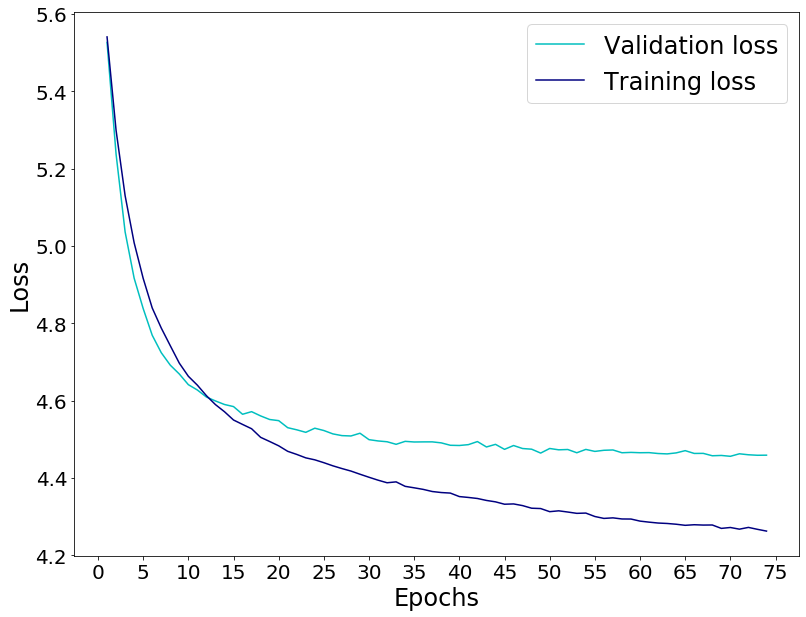

In [12]:
# Plot training and validation loss
epoch = np.arange(len(training_loss))

plt.figure(1, figsize=(13, 10))
plt.plot(epoch[1:], validation_loss[1:], 'c', label='Validation loss')
plt.plot(epoch[1:], training_loss[1:], 'navy', label='Training loss')

plt.legend(fontsize=24)
plt.xlabel('Epochs', fontsize=24), plt.ylabel('Loss',fontsize=24)
plt.xticks(np.arange(0,79,5),fontsize=20)
plt.yticks(fontsize=20)

plt.show()

## Embeddings

In [0]:
import numpy as np
import matplotlib.pyplot as plt
 
from sklearn.manifold import TSNE

#Get embeddings for all words
embed = net.embedding(torch.LongTensor(list(int_to_vocab.keys())).to(device))

arr = np.empty((0,embedding_size), dtype='f')

words = list(vocab_to_int.keys())
        
for word in words:    
    word_label = vocab_to_int[word]
    emb = embed[word_label].cpu().detach().numpy()
    arr = np.append(arr, [emb], axis=0)   
    
    # find tsne coords for 2 dimensions
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(arr)

x_coords = Y[:, 0]
y_coords = Y[:, 1]



In [0]:
from numpy import random
from scipy.spatial import distance

def closest_node(node, nodes,n):
    dist = distance.cdist([node], nodes)
    sorted = np.sort(dist)
  
    take = sorted[0][:n]

    indices = []

    for i in range(len(take)):
      idx = np.where(dist == take[i])
      idx = idx[1].tolist()

      indices.append(idx[0])
    
    return indices


a = []

for i in range(0,len(x_coords)):
    a.append((x_coords[i],y_coords[i]))



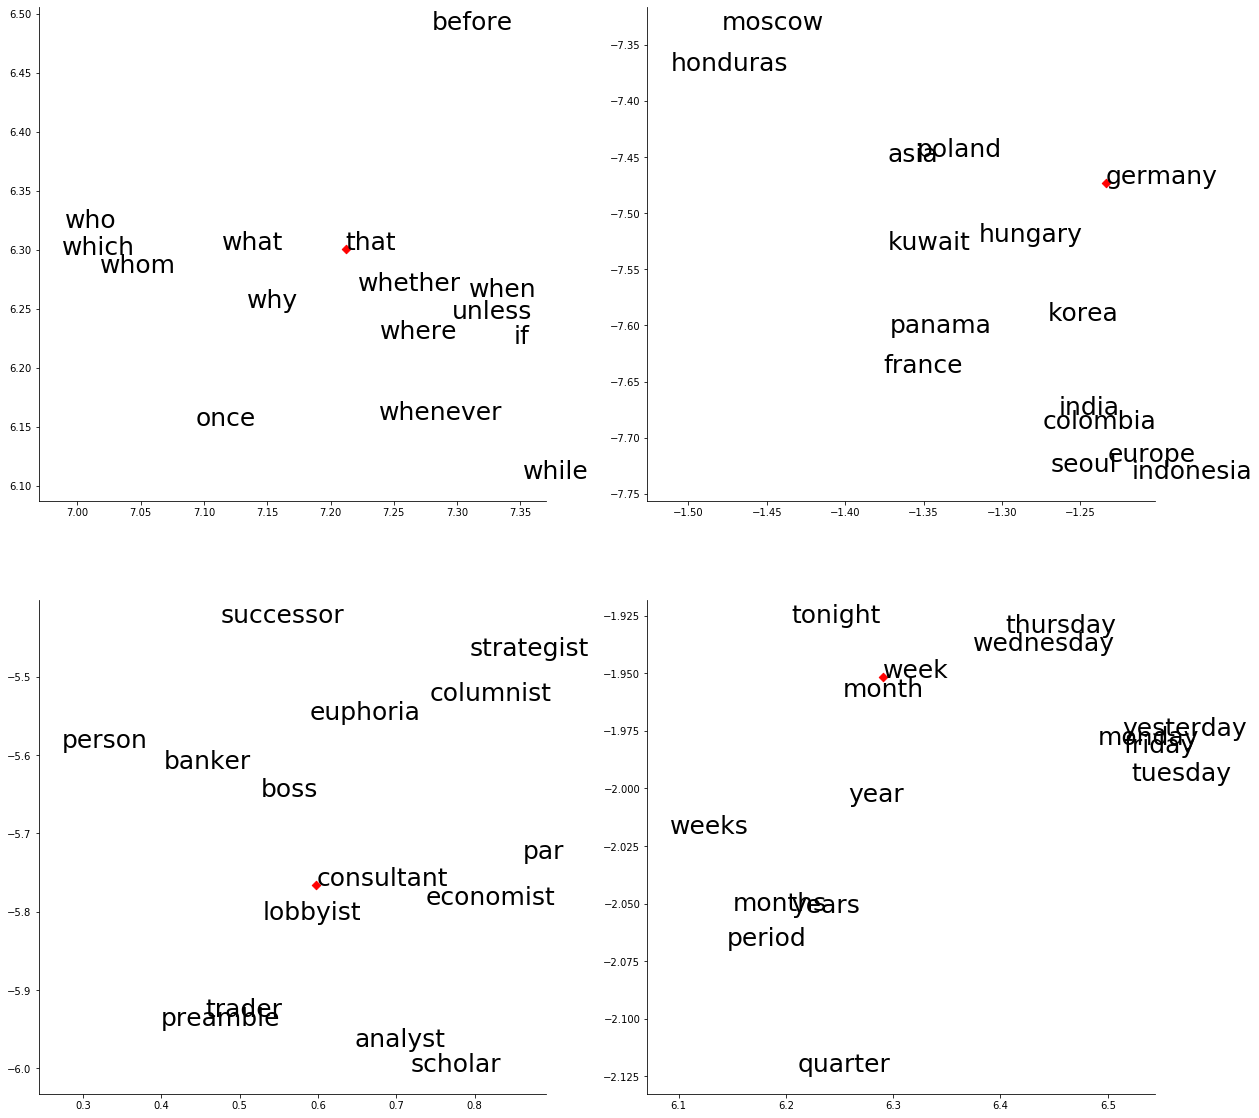

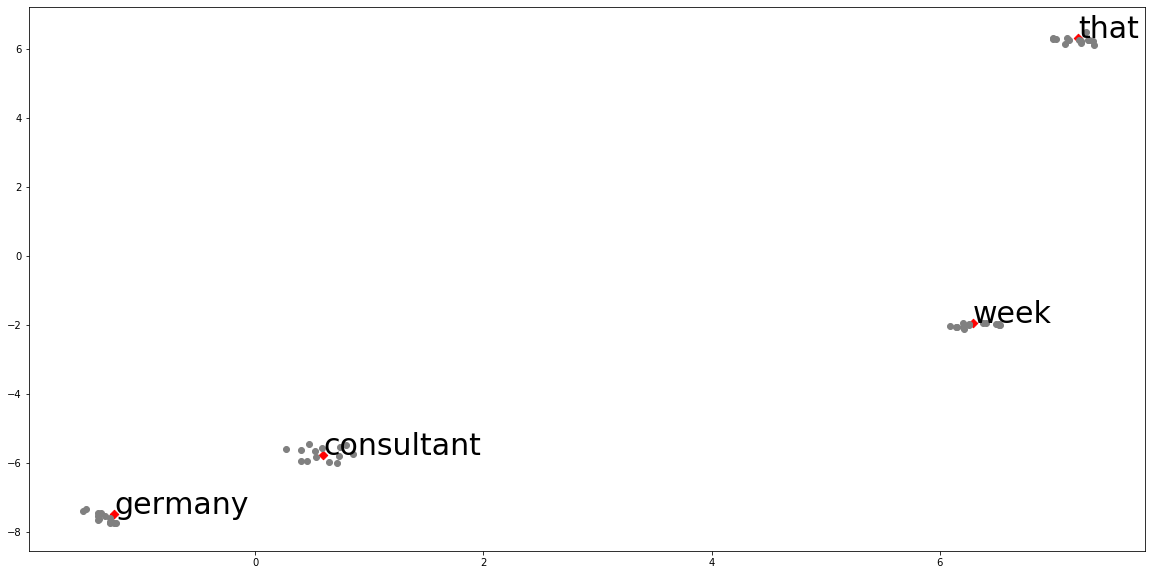

In [0]:


fig = plt.figure(figsize=(20,20))

word_list = ['that','germany','consultant', 'week']
for (word,num) in zip(word_list,range(1,6)):

  k = vocab_to_int[word]


  some_pt = (x_coords[k],y_coords[k])
  ids = closest_node(some_pt, a, 15)


  X = []
  Y = []
  N = []

  for idx in ids:
    X.append(x_coords[idx])
    Y.append(y_coords[idx])
    N.append(words[idx])


  ax = fig.add_subplot(2,2,num)
  ax.scatter(X[0],Y[0],color='red', marker='D')
  ax.scatter(X[1:],Y[1:], color='white', marker='.')
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  
  #ax.set_xlim(min(x_coords),max(x_coords))
  #ax.set_ylim(min(y_coords),max(y_coords))

  
  for i, txt in enumerate(N):
    ax.annotate(txt, (X[i], Y[i]), fontsize=25)


  plt.figure(10, figsize=(20,10))
  plt.scatter(X[0],Y[0],color='red', marker='D')
  plt.annotate(word, xy=(X[0],Y[0]), fontsize=30)
  plt.scatter(X[1:],Y[1:], color='grey', marker='o')

 # plt.gca().spines['right'].set_visible(False)
  #plt.gca().spines['top'].set_visible(False)
 